# Lab:  Nonlinear Least Squares for Modeling Materials

Nonlinear least squares (NLLS) is a widely-used method for modeling data.  In NLLS, we wish to fit a model of the form,

     yhat = g(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  We find `w` by minimizing a least-squares function 

     f(w) = \sum_i (y_i - g(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  This is similar to linear least-squares, but the function `g(x,w)` may not be linear in `w`.  In general, this optimization has no closed-form expression.  So numerical optimization must be used.  

In this lab, we will implement gradient descent on NLLS in a problem of physical modeling of materials.  Specifically, we will estimate parameters for expansion of copper as a function of temperature using a real dataset.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

Lab7
Chin-shu Shao N15778225
Yang Chen N17844016

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [126]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['x0','y0','dummy'])
df.head()

,x0,y0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`. 

Text(0, 0.5, 'y')

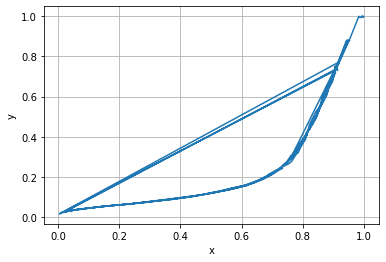

In [127]:
# TODO
x0 = np.array(df['x0'].tolist())
y0 = np.array(df['y0'].tolist())
x = x0 / np.max(x0)
y = y0 / np.max(y0)

plt.plot(x, y)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.05 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

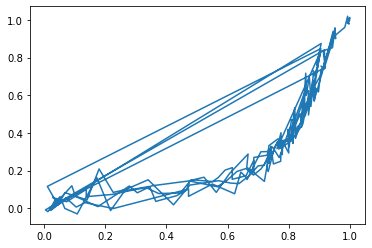

In [128]:
# TODO
yn = y + np.random.normal(0, 0.05, y.shape)
plt.plot(x,yn)

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [129]:
from sklearn.model_selection import train_test_split

# TODO
Xtr, Xts, ytr, yts = train_test_split(x, yn, test_size=0.33, shuffle=True)
args = np.argsort(Xtr)
args1 = np.argsort(Xts)
Xts = Xts[args1]
Xtr = Xtr[args]
yts = yts[args1]
ytr = ytr[args]



## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [130]:
def predict(w,x):
    
    # Get the length
    d = (len(w)-1)//2
    
    # TODO.  Extract a and b from w
    # a = ...
    # b = ...
    a = w[:d+1]
    b = w[d+1:]

    # TODO.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order the a and b
    a_flip = np.flip(a)
    b_flip = np.append([np.flip(b)], 1)

    # yhat = ...
    Zn = np.polyval(a_flip, x) 
    Zd = np.polyval(b_flip, x)
    yhat = Zn / Zd

    return yhat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ] 

In [131]:
d = 3

# TODO.  Create the transformed feature matrix
dp = np.arange(1,d+1)
z = np.zeros((len(Xtr), 6))
for i in range(len(Xtr)):
    z[i,:] = np.concatenate((np.power(Xtr[i],dp),ytr[i]*np.power(Xtr[i],dp)))

# TODO.  Fit with parameters with linear regression
regr = LinearRegression()
regr.fit(z, ytr)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
a = np.append([regr.intercept_],regr.coef_[0:d])
b = -regr.coef_[d:]
winit = np.append(a,b)

Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

(0.0, 1.0)

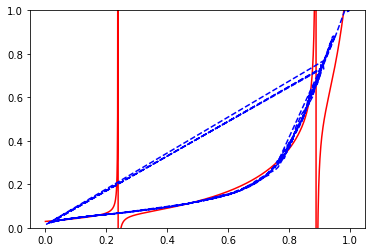

In [132]:
# TODO
xp = np.linspace(0,1,1000)
yhat1 = predict(winit, xp)

plt.plot(xp, yhat1, 'r', x, y, 'b--')
plt.ylim([0,1])

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

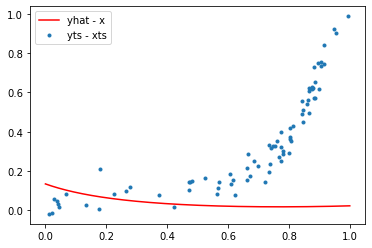

In [133]:
# TODO.  Fit with parameters with linear regression
regr_ridge = Ridge(alpha=1e-3)
regr_ridge.fit(z, ytr)
# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
aR = regr_ridge.coef_
bR = regr_ridge.intercept_
winitR = aR + bR
# TODO
# Plot the results as above.
yhat2 = predict(winitR, xp)
plt.plot(xp, yhat2, 'r', Xts, yts, '.')
plt.legend(['yhat - x', 'yts - xts'], loc='upper left')

## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [134]:
def feval(w,x,y):
# TODO. Parse w 
    
    d = (len(w)-1)//2 
    a = w[0:d+1] 
    b = w[d+1:]
    
    Znum = np.zeros((len(x),d+1))
    for j in range(d+1):
        Znum[:,j] = x[:]**j
        
    Zden = np.zeros((len(x),d))
    for j in range(d):
        Zden[:,j] = x[:]**(j+1)
    yhat = np.zeros(len(x))

    for i in range(len(x)):
        yhat[i] = Znum[i,:].dot(a)/(1+Zden[i,: ] .dot(b))
# TODO. Compute Loss

    f = 0.5*np.sum(np.square(y-yhat))
# TODO. Compute gradients
    grada = np.zeros(len(a)) 
    for j in range(len(a)):
        grada[j] = -np.sum((y-yhat)*Znum[:,j]/(1+np.matmul(Zden,b))) 
    gradb = np.zeros(len(b)) 
    for j in range(len(b)):
        gradb[j] = np.sum((y-yhat)*yhat*Zden[:,j]/(1+np.matmul(Zden,b)))
    fgrad = np.concatenate((grada,gradb))
    return f, fgrad


feval_para = lambda w: feval(w,Xts,yts)

Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [135]:
# TODO
w0 = winit
f0, fgrad0 = feval_para(w0)
lr = 1e-6
w1 = winit + 0.001
f1, fgrad1 = feval_para(w1)
df = f1-f0
df_est = fgrad0.dot(w1-w0)
print('Actual difference:     %12.4e' % df)
print('Estimated difference:  %12.4e' % df_est)

Actual difference:       1.5102e+01
Estimated difference:   -2.0279e+00


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

Text(0, 0.5, 'Training Losee')

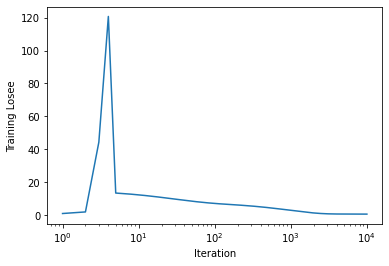

In [136]:
# TODO
# fgd = ...
nit = 10000
step = 1e-6

def grad_opt_simp(feval, winit, step=1e-3, nit=10000):
    hist = {'w':[],'f':[]}
    w0 = winit
    for i in range(nit):
        f, fgrad = feval(w0)
        w0 = w0 - fgrad*step
        hist['w'].append(w0)
        hist['f'].append(f)

    for elem in ('f', 'w'):
        hist[elem] = np.array(hist[elem])
    return w0, f, hist

w0, f, hist = grad_opt_simp(feval_para, winit, step=step, nit=nit)  

t = np.arange(nit)+1
plt.semilogx(t, hist['f'])
plt.xlabel('Iteration')
plt.ylabel('Training Losee')
# plt.grid(color = 'k', linewidth=0.2)

Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

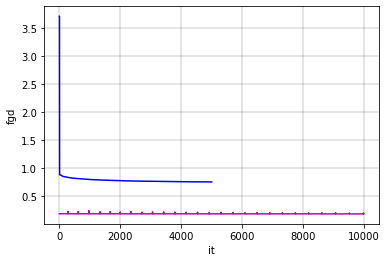

In [137]:
# TODO
# fadapt = ...
nit = 10000
step = 1e-6  # Initial step
alpha = 0.5

w0=winit
hist = {'w':[],'f':[]}


f0, fgrad0=feval(winit,Xtr,ytr) 
for i in range(nit):
    w1 = w0-fgrad0*step
    f1, fgrad1=feval(w1,Xtr,ytr)
    df = fgrad0.dot(w1-w0)
    if(f1-f0 < alpha*df) and (f1<f0):
        step = step*2
        f0 = f1
        fgrad0 = fgrad1
        w0 = w1
    else:
        step = step/2
        hist['w'].append(w0)
        hist['f'].append(f0)

loss_arm = np.array(hist['f'])

plt.plot(loss_arm, 'b-')
plt.plot(loss, 'm-')
plt.xlabel('it')
plt.ylabel('fgd')
plt.grid(color = 'k', linewidth=0.2)


Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

(0.0, 1.0)

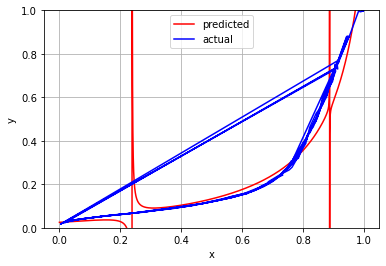

In [139]:
# TODO
# xp = np.linspace(...)
# yhat = ...
# plot(...)
w_adapt_fin = np.array(hist['w'])[5001,:]
xp = np.linspace(0,1,num=10000)
yhat = predict(w_adapt_fin, xp)

plt.plot(xp, yhat, 'r')
plt.plot(x, y, 'b')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().legend(('predicted', 'actual'))
plt.grid()
plt.ylim(0,1)


## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-5`.   Compare the convergence of the loss function with gradient descent.  

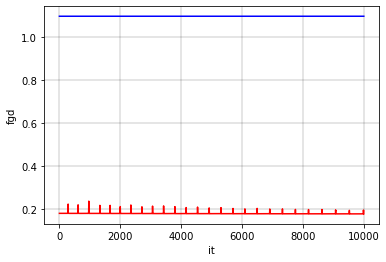

In [140]:
# TODO
nit = 10000
step = 1e-5
beta = 0.99

z = np.zeros(np.shape(winit))
w0=winit
hist = {'w':[],'f':[]}

for i in range(nit):
    f0, fgrad0=feval_para(winit) 
    z = z*beta + fgrad0
    w0 = w0 - z*step
    hist['w'].append(w0)
    hist['f'].append(f0)

loss_mom = np.array(hist['f'])
plt.plot(loss_mom, 'b-')
plt.plot(loss, 'r-')
plt.xlabel('it')
plt.ylabel('fgd')
plt.grid(color = 'k', linewidth=0.2)


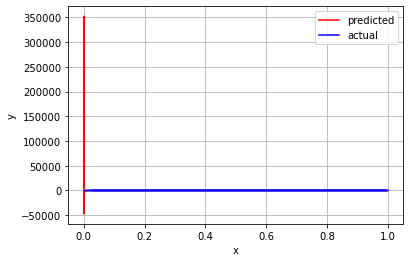

In [70]:
# TODO
# plot yhat vs. x

# plt.plot(x,yhat)
# plt.xlabel()
# plt.ylabel()
# plt.grid()
# plt.show()

w_mom = np.array(hist['w'])[9999,:]
xp = np.linspace(0,1,num=10000)
yhat = predict(w_mom, xp)

plt.plot(xp, yhat, 'r')
plt.plot(x, y, 'b')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().legend(('predicted', 'actual'))
plt.grid()

## Beyond This Lab
In this lab, we have just touched at some of the ideas in optimization.  There are several other important algorithms that you can explore:
* [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) method for non-linear least squares
* Newton's method
* More difficult non-linear least squares problems.

Reference:
Demos, inclass exercise, online gradient descent ml codes